# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [ ]:
17

17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [5]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



The dataset does not contain any null values. In cases of null, they have been labeled as unknown, which we could consider dropping.



In [7]:
# Calculate the number of rows with 'unknown' values in any column
unknown_rows = df[df.isin(['unknown']).any(axis=1)]

# Calculate the percentage of rows that would be dropped
total_rows = len(df)
unknown_rows_count = len(unknown_rows)
percentage_dropped = (unknown_rows_count / total_rows) * 100

unknown_rows_count, percentage_dropped

(10700, 25.978440322424007)


Dropping rows with unknown values would result in downsizing the dataset to 25% of its original size, so it is not a good approach.

At the same time, after an initial analysis, it does not seem that any of the columns would really benefit the case of study from dropping "unknown" values.

On the other hand, we can transform those columns with limited subsets of values into numeric. For instance:


*   Months converted into [1,12]
*   Weekday converted into [1,7]
*   Binary colums into [0,1], including -1 for "unknown"
*   Assigning numeric codes for non-numeric values in job, marital, education, and contact



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The objective is to determine the expected success of customers to subscribe a deposit as a result of the marketing campaign in course

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [9]:
# Define a function to encode specific values
def custom_encode(column):
    mapping = {'yes': 1, 'no': 0, 'unknown': -1}
    return column.map(mapping).fillna(column)

# List of columns to encode
columns_to_encode = ['default', 'housing', 'loan', 'y']

# Apply the custom encoding
for column in columns_to_encode:
    df[column] = custom_encode(df[column])

# Display the first few rows to verify the changes
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,-1,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,0,1,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,0,0,1,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [10]:
# Encode months with [1, 12]
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month'] = df['month'].map(month_mapping)

# Encode days of the week with [1, 7]
day_of_week_mapping = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7
}
df['day_of_week'] = df['day_of_week'].map(day_of_week_mapping)

# Encode contact
contact_mapping = {
    'telephone': 0, 'cellular': 1
}
df['contact'] = df['contact'].map(contact_mapping)

# Encode poutcome
poutcome_mapping = {
    'failure': 0, 'success': 1, 'nonexistent':-1
}
df['poutcome'] = df['poutcome'].map(poutcome_mapping)

# Encode job, marital, and education with numerical sequences
job_mapping = {job: idx for idx, job in enumerate(df['job'].unique(), 1)}
marital_mapping = {marital: idx for idx, marital in enumerate(df['marital'].unique(), 1)}
education_mapping = {education: idx for idx, education in enumerate(df['education'].unique(), 1)}

df['job'] = df['job'].map(job_mapping)
df['marital'] = df['marital'].map(marital_mapping)
df['education'] = df['education'].map(education_mapping)

# Display the first few rows to verify the changes
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,1,1,1,0,0,0,0,5,1,...,1,999,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,2,1,2,-1,0,0,0,5,1,...,1,999,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,2,1,2,0,1,0,0,5,1,...,1,999,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,3,1,3,0,0,0,0,5,1,...,1,999,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,2,1,2,0,0,1,0,5,1,...,1,999,0,-1,1.1,93.994,-36.4,4.857,5191.0,0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [11]:
# Define the features (X) and the target (y)
X = df.drop(columns=['y'])
y = df['y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 20), (8238, 20), (32950,), (8238,))

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [12]:
# A common baseline for classification problems is the performance of a simple model, such as a majority class classifier. This means predicting the most frequent class in the training set for all instances.

baseline_prediction = y_train.mode()[0]
baseline_accuracy = (y_test == baseline_prediction).mean()

baseline_accuracy


0.8865015780529255

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [13]:
# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg_model.predict(X_test)



### Problem 9: Score the Model

What is the accuracy of your model?

In [14]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

accuracy, class_report

(0.9098082058752124,
 '              precision    recall  f1-score   support\n\n           0       0.93      0.97      0.95      7303\n           1       0.67      0.41      0.51       935\n\n    accuracy                           0.91      8238\n   macro avg       0.80      0.69      0.73      8238\nweighted avg       0.90      0.91      0.90      8238\n')

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [ ]:
# Define a function to train and evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    return train_time, train_accuracy, test_accuracy

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42)
}

# Evaluate each model and store results
results = {}
for model_name, model in models.items():
    train_time, train_accuracy, test_accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[model_name] = {
        "Train time": train_time,
        "Train accuracy": train_accuracy,
        "Test accuracy": test_accuracy
    }

# Create a DataFrame to display the results
results_df = pd.DataFrame(results).T



In [ ]:
print(results_df)

                        Train time  Train accuracy  Test accuracy
Logistic Regression       1.147669        0.909165       0.909808
K-Nearest Neighbors       0.008609        0.931745       0.901068
Decision Tree             0.183384        1.000000       0.889294
Support Vector Machine   15.120015        0.898483       0.894513


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [15]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Logistic Regression model with scaled features with max_iter increased to 10000
log_reg_model = LogisticRegression(max_iter=10000, random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = log_reg_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

In [16]:
accuracy, class_report

(0.9081087642631707,
 '              precision    recall  f1-score   support\n\n           0       0.93      0.97      0.95      7303\n           1       0.66      0.40      0.50       935\n\n    accuracy                           0.91      8238\n   macro avg       0.79      0.69      0.72      8238\nweighted avg       0.90      0.91      0.90      8238\n')

In [18]:
# Re-try with scaled data
# Define a function to train and evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    return train_time, train_accuracy, test_accuracy

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42)
}

# Evaluate each model and store results
results = {}
for model_name, model in models.items():
    train_time, train_accuracy, test_accuracy = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    results[model_name] = {
        "Train time": train_time,
        "Train accuracy": train_accuracy,
        "Test accuracy": test_accuracy
    }

# Create a DataFrame to display the results
results_df = pd.DataFrame(results).T


In [19]:
print(results_df)

                        Train time  Train accuracy  Test accuracy
Logistic Regression       0.200293        0.910592       0.908109
K-Nearest Neighbors       0.008289        0.928194       0.901554
Decision Tree             0.182561        1.000000       0.889536
Support Vector Machine   16.795368        0.920637       0.908594


# Logistic Regression Grid Search

In [ ]:
log_reg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

start_time = time.time()
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5)
log_reg_grid.fit(X_train_scaled, y_train)
log_reg_time = time.time() - start_time

best_log_reg = log_reg_grid.best_estimator_
print(f"Best Params for Logistic Regression: {log_reg_grid.best_params_}")
print(f"Time taken for Logistic Regression Grid Search: {log_reg_time:.2f} seconds")

Best Params for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Time taken for Logistic Regression Grid Search: 58.70 seconds


In [24]:
model_lr= LogisticRegression(max_iter=1000, random_state=42, C=0.01, penalty='l2', solver='liblinear')
train_time_lr, train_accuracy_lr, test_accuracy_lr = evaluate_model(model_lr, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Train time: {train_time_lr}")
print(f"Train accuracy: {train_accuracy_lr}")
print(f"Test accuracy: {test_accuracy_lr}")

Train time: 0.25455760955810547
Train accuracy: 0.9108649468892261
Test accuracy: 0.9090798737557659


# K-Nearest Neighbord (KNN)

In [ ]:

knn_param_grid = {
    'n_neighbors': [3, 5, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

start_time = time.time()
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
knn_grid.fit(X_train_scaled, y_train)
knn_time = time.time() - start_time

best_knn = knn_grid.best_estimator_
print(f"Best Params for KNN: {knn_grid.best_params_}")
print(f"Time taken for KNN Grid Search: {knn_time:.2f} seconds")

Best Params for KNN: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
Time taken for KNN Grid Search: 638.76 seconds


In [25]:
model_knn = KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='auto')
train_time_knn, train_accuracy_knn, test_accuracy_knn = evaluate_model(model_knn, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Train time: {train_time_knn}")
print(f"Train accuracy: {train_accuracy_knn}")
print(f"Test accuracy: {test_accuracy_knn}")

Train time: 0.008064985275268555
Train accuracy: 0.9192412746585736
Test accuracy: 0.9031318281136198


# Decission Tree Classifier

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

start_time = time.time()
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5)
dt_grid.fit(X_train_scaled, y_train)
dt_time = time.time() - start_time

best_dt = dt_grid.best_estimator_
print(f"Best Params for Decision Tree: {dt_grid.best_params_}")
print(f"Time taken for Decision Tree Grid Search: {dt_time:.2f} seconds")

Best Params for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Time taken for Decision Tree Grid Search: 80.79 seconds


In [26]:
model_dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=2, max_features='sqrt',random_state=42)
train_time_dt, train_accuracy_dt, test_accuracy_dt = evaluate_model(model_dt, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Train time: {train_time_dt}")
print(f"Train accuracy: {train_accuracy_dt}")
print(f"Test accuracy: {test_accuracy_dt}")

Train time: 0.055605411529541016
Train accuracy: 0.9287101669195751
Test accuracy: 0.9100509832483612


# SVC

In [ ]:
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

start_time = time.time()
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5)
svm_grid.fit(X_train_scaled, y_train)
svm_time = time.time() - start_time

best_svm = svm_grid.best_estimator_
print(f"Best Params for SVM: {svm_grid.best_params_}")
print(f"Time taken for SVM Grid Search: {svm_time:.2f} seconds")

Best Params for SVM: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Time taken for SVM Grid Search: 5131.11 seconds


In [27]:
model_svc = SVC(C=1, kernel='rbf', gamma='auto', random_state=42)
train_time_svc, train_accuracy_svc, test_accuracy_svc = evaluate_model(model_svc, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Train time: {train_time_svc}")
print(f"Train accuracy: {train_accuracy_svc}")
print(f"Test accuracy: {test_accuracy_svc}")

Train time: 18.08459162712097
Train accuracy: 0.9206373292867982
Test accuracy: 0.9085943190094683


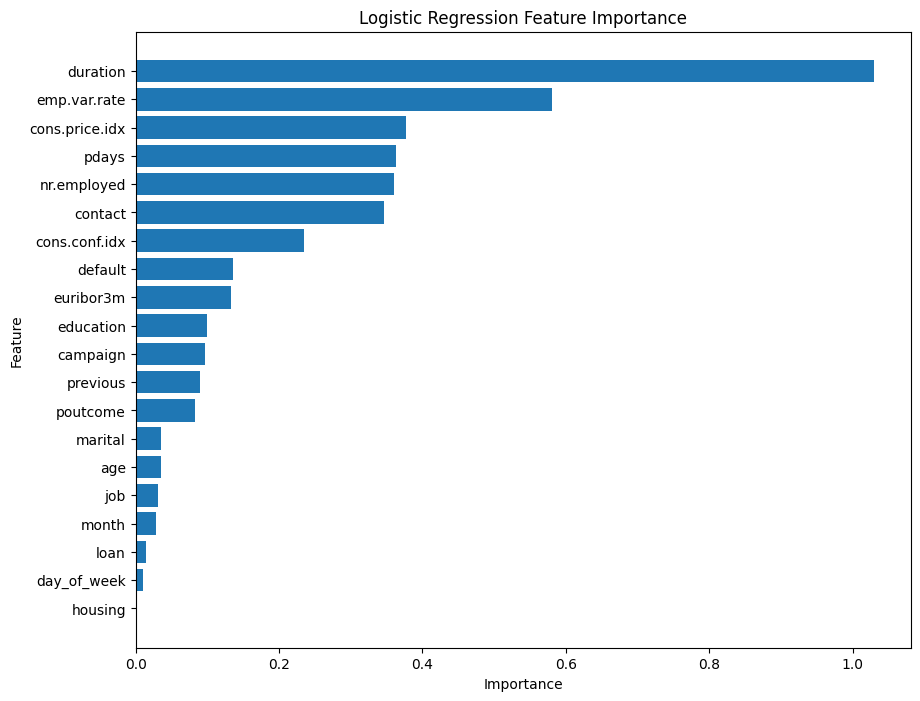

In [33]:
# Assuming best_log_reg is the best logistic regression model obtained from GridSearchCV
coefficients = model_lr.coef_[0]
features = X_train.columns

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.gca().invert_yaxis()
plt.show()

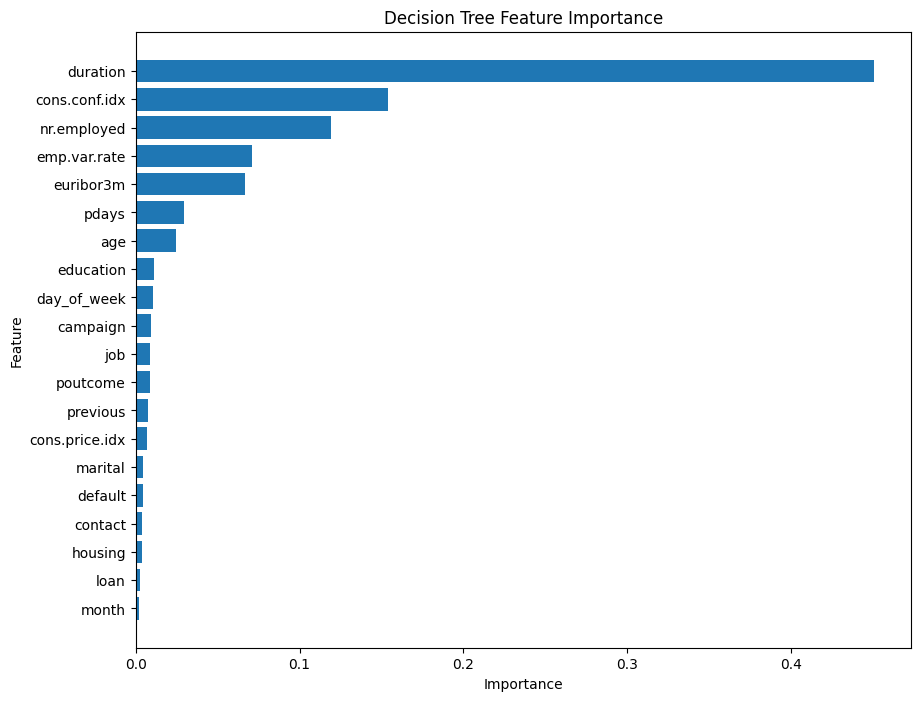

In [31]:
# Assuming best_dt is the best decision tree model obtained from GridSearchCV
importances = model_dt.feature_importances_
features = X_train.columns

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()
plt.show()

##### Questions